# Imports

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patheffects as path_effects
from scipy.optimize import fsolve
from turtle import color


## 1.  Optimal foraging of individual agent

### Heatmaps: $\epsilon$($s$, $a$|$r$) for $r\in{100, 200, 300}$

C:\Users\tester.LAPTOP-NJPROMP8\AppData\Local\Temp\ipykernel_3984\3994963190.py:87: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\tester.LAPTOP-NJPROMP8\OneDrive - Universidade de Lisboa\Aaa Técnico\1. MEIC\AASMA\foraging-sim\venv_aasma\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


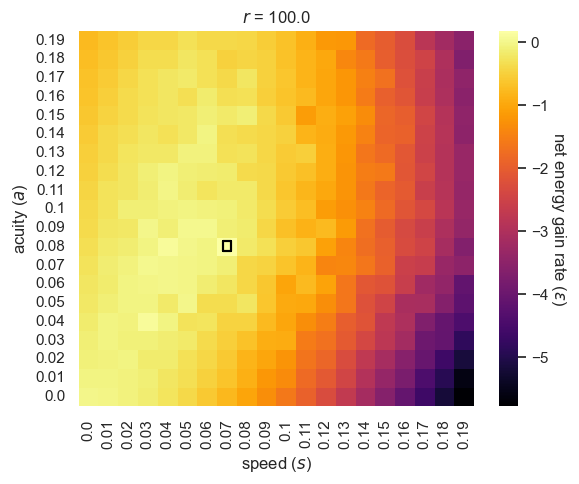

C:\Users\tester.LAPTOP-NJPROMP8\AppData\Local\Temp\ipykernel_3984\3994963190.py:87: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\tester.LAPTOP-NJPROMP8\OneDrive - Universidade de Lisboa\Aaa Técnico\1. MEIC\AASMA\foraging-sim\venv_aasma\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


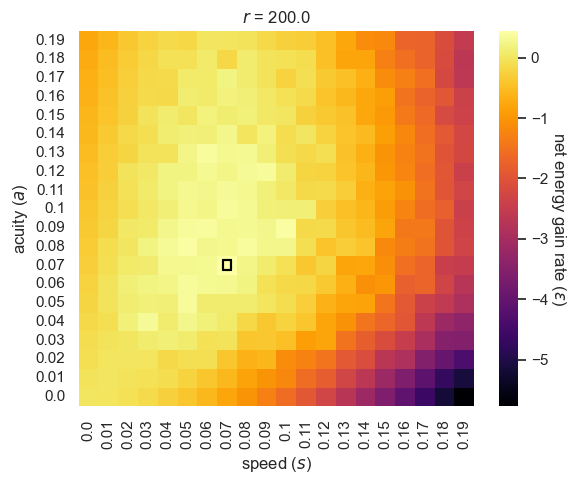

C:\Users\tester.LAPTOP-NJPROMP8\AppData\Local\Temp\ipykernel_3984\3994963190.py:87: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\tester.LAPTOP-NJPROMP8\OneDrive - Universidade de Lisboa\Aaa Técnico\1. MEIC\AASMA\foraging-sim\venv_aasma\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


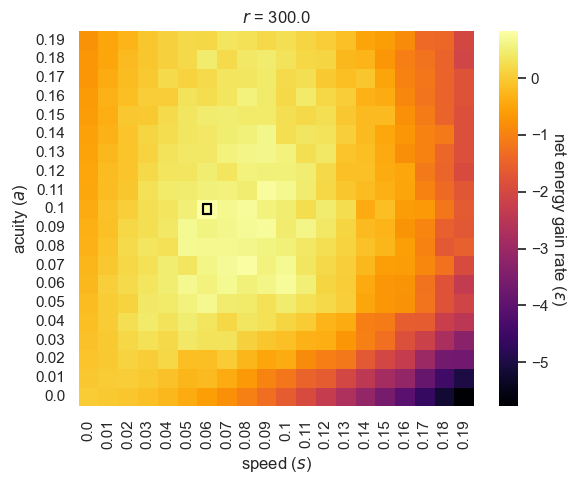

In [161]:
# Parameters
F = 1                # resource energy
c_s = 160
c_a = 4
generations = 1000   # number of generations
delta_t = 0.1        # time between generations

# Colours for maximum values
star_colors = {
    100: "blue",
    200: "orange",
    300: "green"
}

# Load agent-level data
df = pd.read_csv("./simulation_results/3_1_energy.csv", delimiter=",")
df = df.apply(pd.to_numeric, errors="coerce")

# epsilon = energy / time = energy / (generations * time between generations)
df["net_energy_gain_rate"] = df["energy"] / (generations * delta_t)

# Get sorted unique values of 'Rate'
r_values = sorted(df["Rate"].unique())

# Loop over each Rate value and create an independent figure
for r_value in r_values:
    # Filter data for current Rate value
    subset = df[df["Rate"] == r_value]

    # Create pivot table for heatmap
    pivot_table = subset.pivot_table(
        index='acuity',
        columns='speed',
        values='net_energy_gain_rate'
    )

    # Create a new figure for each plot
    plt.figure(figsize=(6, 5))

    # Create the heatmap
    heatmap = sns.heatmap(
        pivot_table,
        cmap="inferno",
        cbar=True
    )

    # Add colorbar and label
    cbar = heatmap.collections[0].colorbar
    cbar.set_label(r"net energy gain rate ($\varepsilon$)", rotation=-90, labelpad=15, fontsize=12)

    # Add title and axis labels
    plt.title(fr"$r$ = {r_value}")
    plt.xlabel(r"speed ($s$)")
    plt.ylabel(r"acuity ($a$)")

    # Flip y-axis so that higher speed is at the top
    plt.gca().invert_yaxis()

    # Find maximum net energy gain rate
    max_val = pivot_table.max().max()

    # Find net energy gain rate maximizers
    max_coords = np.where(pivot_table == max_val)

    star_color = star_colors.get(r_value, "white")

    # Mark maximum in the heatmap
    for y_idx, x_idx in zip(*max_coords):
        text = plt.text(
            x=x_idx + 0.5,
            y=y_idx + 0.5,
            s="★",
            color=star_color,
            ha='center',
            va='center',
            fontsize=12,
            fontweight='bold'
        )
        
        # Add back contour
        text.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()
        ])

    # Display the figure
    plt.tight_layout()
    plt.show()


### Plot $\mathcal{L}(a)$ vs $a$

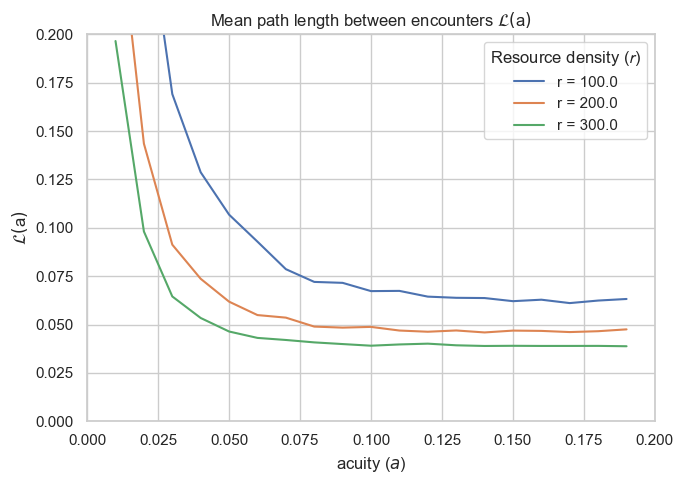

In [162]:
# C = c_s * s^2 + c_a * a
df["metabolic_cost"] = c_s * df["speed"]**2 + c_a * df["acuity"]

# ni = (epsilon + C) / F
df["resources_per_time"] = (df["net_energy_gain_rate"] + df["metabolic_cost"]) / F

# Compute mean path length between encounters
with np.errstate(divide='ignore', invalid='ignore'):
    df["L"] = df["speed"] / df["resources_per_time"]

df = df[(df["L"] >= 1e-5) & (df["L"] <= 1e5)]

# Plot 𝓛(a) vs. acuity for each resource density r
plt.figure(figsize=(7, 5))

# Loop over each Rate
for r_value in sorted(df["Rate"].unique()):
    subset = df[df["Rate"] == r_value]


    # Group by acuity and calculate mean L (if needed)
    grouped = subset.groupby("acuity")["L"].mean().reset_index()

    # Plot line
    plt.plot(grouped["acuity"], grouped["L"], label=f"r = {r_value}")

# Labels and title
plt.xlabel(r"acuity ($a$)")
plt.ylabel(r"$\mathcal{L}($a$)$")
plt.title(r"Mean path length between encounters $\mathcal{L}($a$)$")
plt.legend(title=r"Resource density ($\mathcal{r}$)")
plt.xlim(0,0.2)
plt.ylim(0,0.2)
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot $\frac{d}{da}[g^2]$ vs $a$

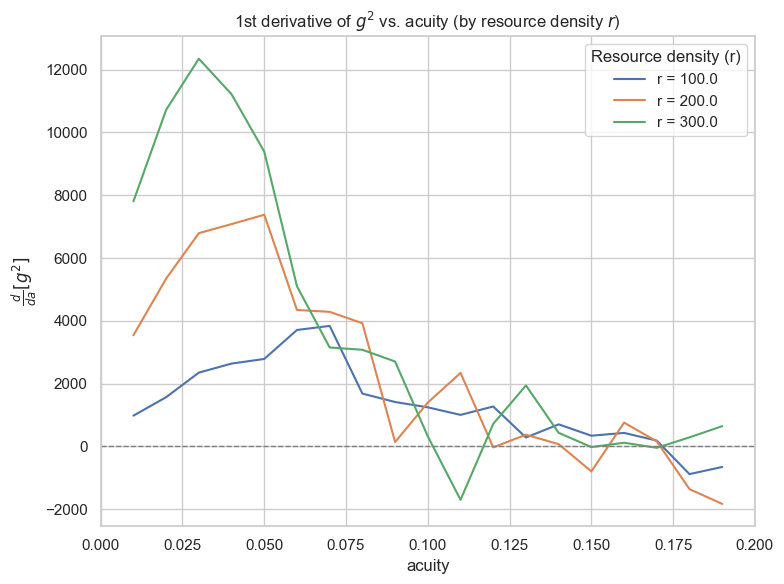

In [163]:
df = df.dropna(subset=["L"])
plt.figure(figsize=(8, 6))

# Loop through each resource density r
for r_value in sorted(df["Rate"].unique()):
    # Filter and sort by acuity
    subset = df[df["Rate"] == r_value]

    # Group by acuity and calculate mean L
    grouped = subset.groupby("acuity")["L"].mean().reset_index()
    a = grouped["acuity"].values
    L = grouped["L"].values
    
    with np.errstate(divide='ignore', invalid='ignore'):
        g = 1 / L
        g2 = g**2
        # Compute gradient pf g2 w.r.t. a
        dg2_da = np.gradient(g2, a)

    # Plot the derivative curve for this r
    plt.plot(a, dg2_da, label=f"r = {r_value}")

# Add horizontal dashed line at y=0 (without duplicate label)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Labels and layout
plt.xlabel("acuity")
plt.ylabel(r"$\frac{d}{da}[g^2]$")
plt.title("1st derivative of $g^2$ vs. acuity (by resource density $r$)")
plt.xlim(0, 0.2)
#plt.ylim(-1e4, 4e4)
plt.grid(True)
plt.legend(title="Resource density (r)")
plt.tight_layout()
plt.show()


## 2. Steady-state of a population using single strategy

### Heatmaps: $log_{10}(n*)$ and $log_{10}(N)$

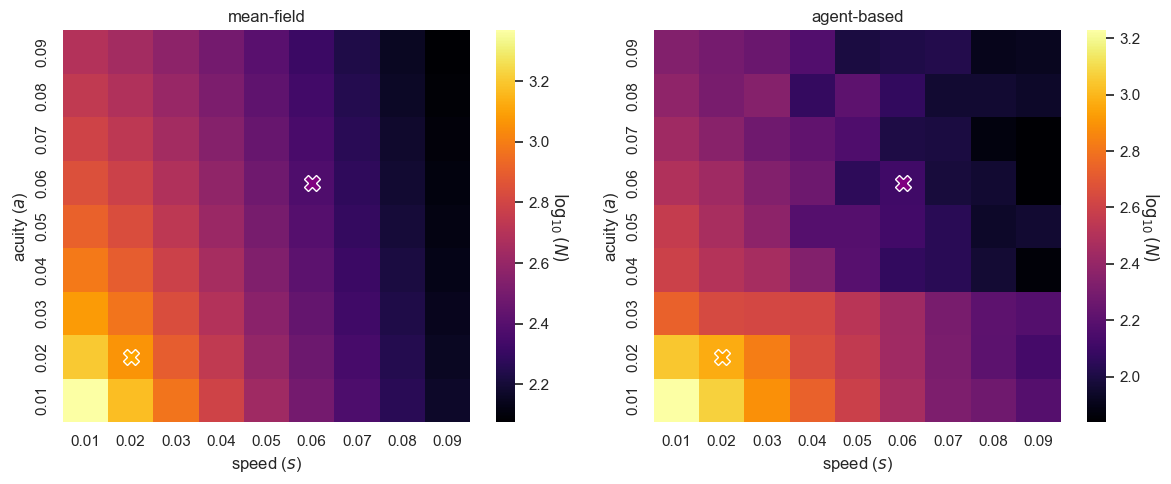

In [164]:
# Parameters 
alpha = 4
beta = 1
delta_0 = 5e-3
delta = 1
K_b = 10
K_d = 1.0
F = 200
resource_generation_rate = 1

# Function that represents b(E) - d(E)
def f(E):
    E_alpha = E**alpha
    b = beta * (E_alpha / (E_alpha + K_b**alpha))
    d = delta_0 + delta * (K_d**alpha / (E_alpha + K_d**alpha))
    return b - d

initial_guess = 1.0

# Solve b(E) = d(E) to obtain E*
E_star = fsolve(f, initial_guess)[0]
E_alpha = E_star**alpha

# Load agent-level data
df = pd.read_csv("./simulation_results/3_2_1000Steps_500pop.csv", delimiter=",")
df = df.apply(pd.to_numeric, errors="coerce")
df[["acuity", "speed"]] = df[["acuity", "speed"]].round(2)

# Mean-field computation
df["metabolic_cost"] = c_s * df["speed"]**2 + c_a * df["acuity"]
df["birth_rate"] = beta * E_alpha / (E_alpha + K_b**alpha)
df["n*"] = resource_generation_rate * F / (df["metabolic_cost"] + df["birth_rate"] * np.log(2) * E_star)
df["log_10_n*"] = np.log10(df["n*"])

# Agent-based log10 population
df["log10_N"] = np.log10(df["population"])

# Create pivot tables
pivot_meanfield = df.pivot_table(index='acuity', columns='speed', values='log_10_n*')
pivot_agentbased = df.pivot_table(index='acuity', columns='speed', values='log10_N')

# Get positions (row index and column index) for the specific acuity/speed pairs
def get_heatmap_coords(pivot_table, acuity_val, speed_val):
    row = np.where(pivot_table.index == acuity_val)[0][0]
    col = np.where(pivot_table.columns == speed_val)[0][0]
    return col + 0.5, row + 0.5  # shift by 0.5 to center the marker in the heatmap cell

# Coordinates for the two points
x1, y1 = get_heatmap_coords(pivot_meanfield, 0.02, 0.02)
x2, y2 = get_heatmap_coords(pivot_meanfield, 0.06, 0.06)

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Mean-field
sns.heatmap(pivot_meanfield, cmap="inferno", cbar=True, ax=axs[0])
axs[0].set_title("mean-field")
axs[0].set_xlabel(r"speed ($s$)")
axs[0].set_ylabel(r"acuity ($a$)")
axs[0].invert_yaxis()
axs[0].collections[0].colorbar.set_label(r"$\log_{10}(N)$", rotation=-90, labelpad=15)

# Mark points on mean-field
axs[0].plot(x1, y1, marker='X', color='orange', markersize=12, markeredgecolor='white')
axs[0].plot(x2, y2, marker='X', color='purple', markersize=12, markeredgecolor='white')

# Agent-based
sns.heatmap(pivot_agentbased, cmap="inferno", cbar=True, ax=axs[1])
axs[1].set_title("agent-based")
axs[1].set_xlabel(r"speed ($s$)")
axs[1].set_ylabel(r"acuity ($a$)")
axs[1].invert_yaxis()
axs[1].collections[0].colorbar.set_label(r"$\log_{10}(N)$", rotation=-90, labelpad=15)

# Mark points on agent-based
axs[1].plot(x1, y1, marker='X', color='orange', markersize=12, markeredgecolor='white')
axs[1].plot(x2, y2, marker='X', color='purple', markersize=12, markeredgecolor='white')

plt.tight_layout()
plt.show()

### Plots: Convergence to steady-state population

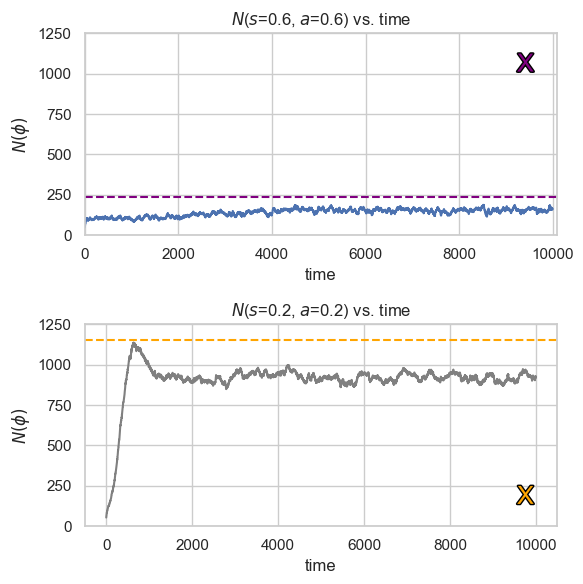

In [165]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Load data from CSV file for speed=0.02 and acuity=0.02
df1 = pd.read_csv("./simulation_results/pop_0.02_0.02.csv", delimiter=",")
df1 = df1.apply(pd.to_numeric, errors="coerce")
# Extract the "n*" value from dataframe df where speed and acuity are close to 0.02
N1 = df[np.isclose(df["speed"], 0.02) & np.isclose(df["acuity"], 0.02)]["n*"].values

axs[1].plot(df1["step"], df1["population"], color="grey")
axs[1].set_xlabel("time")
axs[1].set_ylabel(r"$N(\phi)$")
axs[0].set_xlim(0, 10100)
axs[1].set_ylim(0, 1250)
axs[1].set_title(r"$N$($s$=0.2, $a$=0.2) vs. time")
# Add dashed orange line (asymptote) at y = N1
line = axs[1].axhline(y=N1, color='orange', linestyle='--')
star_text = axs[1].text(0.95, 0.2, "X", transform=axs[1].transAxes,
                       fontsize=18, color="orange", ha="right", va="top")
star_text.set_path_effects([
    path_effects.Stroke(linewidth=2, foreground='black'),
    path_effects.Normal()
])


# Load data from CSV for speed=0.06 and acuity=0.06
df2 = pd.read_csv("./simulation_results/pop_0.06_0.06.csv", delimiter=",")
df2 = df2.apply(pd.to_numeric, errors="coerce")
# Extract "n*" value for speed=0.06 and acuity=0.06
N2 = df[np.isclose(df["speed"], 0.06) & np.isclose(df["acuity"], 0.06)]["n*"].values

axs[0].plot(df2["step"], df2["population"])
axs[0].set_xlabel("time")
axs[0].set_ylabel(r"$N(\phi)$")
axs[0].set_xlim(0, 10100)
axs[0].set_ylim(0, 1250)
axs[0].set_title(r"$N$($s$=0.6, $a$=0.6) vs. time")
# Add dashed purple line (asymptote) at y = N2
line = axs[0].axhline(y=N2, color='purple', linestyle='--')
star_text2 = axs[0].text(0.95, 0.9, "X", transform=axs[0].transAxes,
                        fontsize=18, color="purple", ha="right", va="top")
star_text2.set_path_effects([
    path_effects.Stroke(linewidth=2, foreground='black'),
    path_effects.Normal()
])

plt.tight_layout()
plt.show()

## 3. Selection between strategies with the same metabolic cost

C:\Users\tester.LAPTOP-NJPROMP8\AppData\Local\Temp\ipykernel_3984\2019809853.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = subset.groupby('cost_bin').agg({
C:\Users\tester.LAPTOP-NJPROMP8\AppData\Local\Temp\ipykernel_3984\2019809853.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = subset.groupby('cost_bin').agg({
C:\Users\tester.LAPTOP-NJPROMP8\AppData\Local\Temp\ipykernel_3984\2019809853.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a

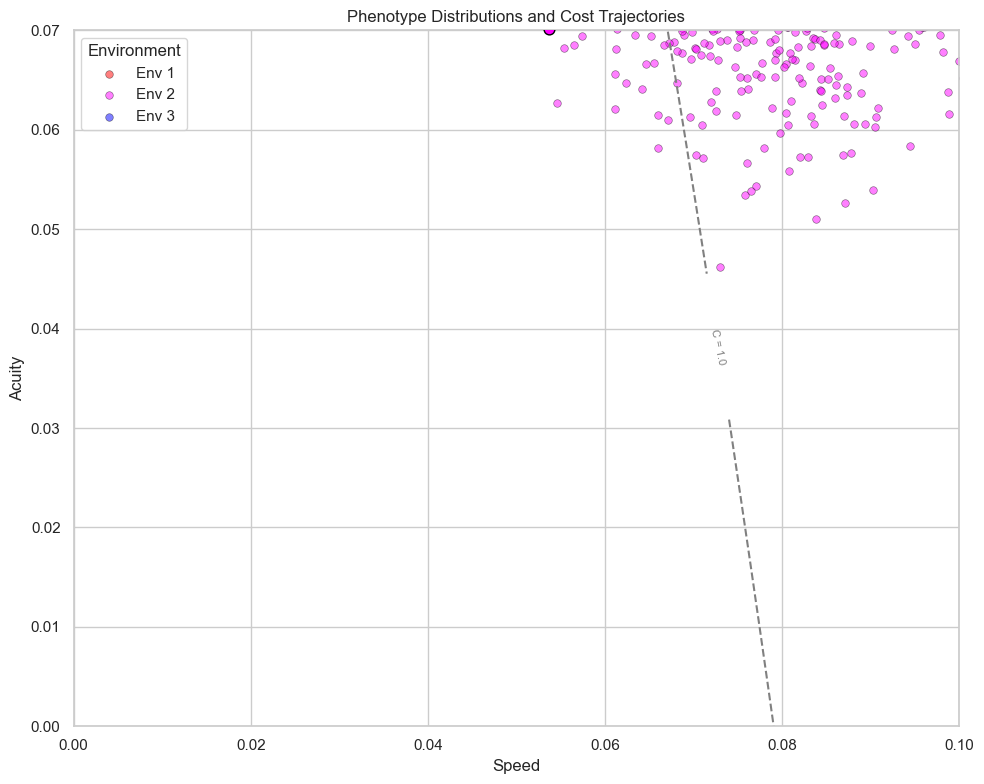

In [ ]:
# --- Assume df1, df2, df3 are defined ---
dfs = [df1, df2, df3]
labels = ['Env 1', 'Env 2', 'Env 3']
colors = ['red', 'magenta', 'blue']

# Add environment column
for df, label in zip(dfs, labels):
    df['environment'] = label

# Combine into one DataFrame
all_data = pd.concat(dfs, ignore_index=True)

# Plot base scatter
plt.figure(figsize=(10, 8))
sns.set(style='whitegrid')

# Plot points
for label, color in zip(labels, colors):
    subset = all_data[all_data['environment'] == label]
    sns.scatterplot(
        data=subset,
        x='speed',
        y='acuity',
        label=label,
        color=color,
        alpha=0.5,
        edgecolor='black',
        s=30
    )

# --- Compute and plot the average (speed, acuity) per cost level for each environment ---
# Bin the metabolic cost (optional: adjust bin width)
all_data['cost_bin'] = pd.cut(all_data['metabolic_cost'], bins=np.arange(0, all_data['metabolic_cost'].max() + 0.2, 0.2))

for label, color in zip(labels, colors):
    subset = all_data[all_data['environment'] == label]

    # Group by cost_bin and calculate average speed/acuity
    grouped = subset.groupby('cost_bin').agg({
        'speed': 'mean',
        'acuity': 'mean'
    }).dropna().reset_index()

    # Plot the curve connecting the averages (without adding to legend)
    plt.plot(grouped['speed'], grouped['acuity'], color=color, linestyle='-', linewidth=2)

    # Mark the average points (also without label)
    plt.scatter(grouped['speed'], grouped['acuity'], color=color, edgecolor='black', s=60, zorder=3)

# --- Optionally overlay iso-cost contours ---
c_s = 160
c_a = 4
speed_grid = np.linspace(0, 0.2, 200)
acuity_grid = np.linspace(0, 0.2, 200)
S, A = np.meshgrid(speed_grid, acuity_grid)
C = c_s * S**2 + c_a * A

levels = [1, 2, 3, 4]
contours = plt.contour(S, A, C, levels=levels, colors='gray', linestyles='dashed')
plt.clabel(contours, inline=True, fmt='C = %.1f', fontsize=8)

# Final plot setup
plt.xlabel("Speed")
plt.ylabel("Acuity")
plt.title("Phenotype Distributions and Cost Trajectories")
plt.xlim(0, 0.1)
plt.ylim(0, 0.07)
plt.legend(title='Environment')
plt.tight_layout()
plt.show()